Xu et al. (Xu et al.: [How Powerful are Graph Neural Networks?](https://arxiv.org/pdf/1810.00826). **2018**) present an interesting analysis of the expressive power of graph neural networks (GNN) and show that basic GNN architectures (e.g. GCN (graph convolutional networks)) cannot be more powerful than the Weisfeiler-Lehman graph isomorphism test. Xu et al. highlight that the mean-based aggregation in GCN results in situations in that simple certain simple graph structures cannot be distinguished. They introduce GIN (*Graph Isomorphism Network*) and show that due to its sum-based aggregation GINs can distinguish between more similar graphs. Despite this theoretical advantage, GIN does not always yield better performance in practice compared to GCN. In this notebook, we will use the [QM9](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html) to test how well GIN performs im comparison to GIN. Specifically, we will only look at the prediction of the *gap* (between HOMO and LUMO).

However, also GIN fails to distinguish certain simple graph structures (e.g., Decalin vs Bicyclopentyl). Bouritsas et al. (Bouritsas et al.: [Improving Graph Neural Network Expressivity via Subgraph Isomorphism Counting](https://arxiv.org/pdf/2006.09252). **2021**) show that incorporating substructure counts can alleviate some of these problems. Thus in a second step, in this notebook we are also evaluating if supplying a GIN with substructure counts of ring sizes from 3 to 8 as additional features improves performance: 

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import math
import matplotlib.pyplot as plt
from itertools import product
import random
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from scipy.sparse import coo_matrix
from torch_geometric.data import Data
from torch_geometric.nn.conv import GCNConv, GINConv
from torch_geometric.nn.norm import GraphNorm
from torch_geometric.nn.aggr import (
    MultiAggregation, MeanAggregation, StdAggregation, SoftmaxAggregation, SumAggregation)
from torch_geometric.loader import DataLoader as DataLoader_pyg
import torch_geometric.transforms as T
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
import logging
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*The number of training batches*")
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
plt.rcParams["figure.dpi"] = 300
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

n_train = 30000
n_val = 10000
n_test = 10000

use_edge_attr = False
transforms = T.Compose([T.VirtualNode()])
batch_size = 512
ring_sizes = [3, 4, 5, 6, 7, 8]

Our featurizer to convert SMILES strings into graph data. The *get_x_w_ring_feats* will supply ring size features:

In [2]:
class MoleculeProcessor:
    def __init__(self, atom_types=None, bond_types=None, use_edge_attr=False, 
                 transforms=None, ring_sizes=None):
        if atom_types is None:
            atom_types = []
        self.dic_atoms = {symbol: idx for idx, symbol in enumerate(atom_types)}
        if bond_types is None:
            bond_types = []
        self.dic_bonds = {symbol: idx for idx, symbol in enumerate(bond_types)}
        self.transforms = transforms
        self.use_edge_attr = use_edge_attr
        self.ring_sizes = ring_sizes
    
    @staticmethod
    def smile_to_mol(smile):
        return Chem.MolFromSmiles(smile)
    
    def smile_to_data(self, smile, y=None):
        mol = MoleculeProcessor.smile_to_mol(smile)
        edge_idx, _, n_edges = self.get_edge_idx(mol)
        if self.ring_sizes is not None:
            x = self.get_x_w_ring_feats(mol)
        else:
            x = self.get_x(mol)
            
        edge_attr = None
        if self.use_edge_attr:
            edge_attr = self.get_edge_attr(mol, edge_idx, n_edges)
        
        data = Data(x=x, edge_index=edge_idx, edge_attr=edge_attr, y=y)
        if self.transforms is not None:
            return self.transforms(data)
        return data
        
    def smiles_to_datalist(self, smiles, y=None):
        data = []
        for idx, smile in enumerate(smiles):
            if y is None:
                data.append(self.smile_to_data(smile, None))
            else:
                data.append(
                    self.smile_to_data(smile, torch.tensor(y[idx]).float()))
        return data
    
    def get_x(self, mol):
        x = np.array([[self.dic_atoms[atom.GetSymbol()] for atom in mol.GetAtoms()]])
        return torch.tensor(x.T).type(torch.float32)
    
    def get_x_w_ring_feats(self, mol):
        n_atoms = len(mol.GetAtoms())
        
        x = np.zeros((n_atoms, len(self.ring_sizes)+1))
        x[:, 0] = [self.dic_atoms[atom.GetSymbol()] for atom in mol.GetAtoms()]
        
        rings = mol.GetRingInfo().AtomRings()
        
        for idx0, ring_size in enumerate(self.ring_sizes):
            rings_cur = [x for x in rings if len(x) == ring_size]
            idx1, counts = np.unique(rings_cur, return_counts=True)
            if idx1.shape[0] > 0:
                x[idx1, idx0+1] = counts / 2 # / 2 for normalization. atoms can typically be expected to not be part of more than 2 ring systems at once
        return torch.tensor(x).type(torch.float32)
    
    def get_edge_idx(self, mol):
        adj = coo_matrix(Chem.GetAdjacencyMatrix(mol))
        edge_idx = torch.stack(
            [torch.from_numpy(adj.row).to(torch.long),
             torch.from_numpy(adj.col).to(torch.long)],
            dim=0
            )
        n_nodes = adj.shape[0]
        n_edges = int(np.sum(adj))
        return edge_idx, n_nodes, n_edges
    
    def get_edge_attr(self, mol, edge_idx, n_edges):
        edge_attr = np.zeros((n_edges,), dtype=int)
        for count, (idx1, idx2) in enumerate(zip(edge_idx[0], edge_idx[1])):
            bond_type = str((mol).GetBondBetweenAtoms(
                int(idx1), int(idx2)).GetBondType())
            edge_attr[count] = self.dic_bonds[bond_type] + 1
            
        edge_attr = torch.from_numpy(edge_attr).type(torch.float32)
        return edge_attr

    def _atom_type(self, smile, idx, check_validity):
        try:
            mol = MoleculeProcessor.smile_to_mol(smile)
            atom_types = [str(atom.GetSymbol()) for atom in mol.GetAtoms()]
            if check_validity:
                invalid = [
                    x for x in atom_types if x not in self.dic_atom.keys()]
                if len(invalid) > 0:
                    raise Exception(f"Atoms {invalid} not allowed")
            return atom_types, []
        except:
            return [], [idx]
    
    def get_atom_types(self, smiles, check_validity=False):
        atom_types = set()
        idx_exception = []
        for idx, smile in enumerate(smiles):
            atom_types_cur, idx_exception_cur = self._atom_type(
                smile, idx, check_validity)
            atom_types.update(atom_types_cur)
            idx_exception.extend(idx_exception_cur)
        return sorted(atom_types), idx_exception
    
    def get_bond_types(self, smiles):
        bond_types = set()
        idx_exception = []
        for idx, smile in enumerate(smiles):
            try:
                mol = MoleculeProcessor.smile_to_mol(smile)
                bond_types_cur = [
                    str(bond.GetBondType()) for bond in mol.GetBonds()]
                bond_types.update(bond_types_cur)
            except:
                idx_exception.append(idx)
        return sorted(bond_types), idx_exception
    
    def plot(self, smiles, labels=None, n_cols=3, figsize=None):
        cols = len(smiles) if len(smiles) < n_cols else n_cols
        rows = math.ceil(len(smiles) / cols)

        if len(smiles) > 1:
            fig, ax = plt.subplots(rows, cols, figsize=figsize)
        else:
            fig, ax = plt.subplots(figsize=figsize)
        
        for idx0, (idx1, idx2) in enumerate(
                product(range(rows), range(cols))):
            if len(smiles) == 1:
                obj = ax
            elif rows <= 1:
                obj = ax[idx2]
            elif cols <= 1:
                obj = ax[idx1]
            else:
                obj = ax[idx1, idx2]
            
            if idx0 < len(smiles):
                obj.imshow(Draw.MolToImage(self.smile_to_mol(smiles[idx0])))
                if labels is not None:
                    obj.set_title(labels[idx0])
            else:
                try:
                    fig.delaxes(obj)
                except:
                    pass
        if len(smiles) > 1:
            [axi.set_axis_off() for axi in ax.ravel()]
        else:
            ax.set_axis_off()
        plt.tight_layout()
        plt.show()


df = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv")

processor_ = MoleculeProcessor()
atom_types, _ = processor_.get_atom_types(df["smiles"].tolist())
bond_types, _ = processor_.get_bond_types(df["smiles"].tolist())
processor0 = MoleculeProcessor(
    atom_types, bond_types, use_edge_attr, transforms)
processor2 = MoleculeProcessor(
    atom_types, bond_types, use_edge_attr, transforms, ring_sizes)

Next, we will split into train, validation and test data set and create the basic dataloader (without substructure counts):

In [3]:
df_train = df.sample(n=n_train, random_state=seed)
df = df[~df.index.isin(df_train.index)].reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

df_val = df.sample(n=n_val, random_state=seed)
df_test = df[~df.index.isin(df_val.index)].reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

df_test = df_test.sample(n=n_test, random_state=seed)

# Without exogenouse features
ds_train0 = processor0.smiles_to_datalist(
    df_train["smiles"].tolist(), df_train["gap"].values)
ds_val0 = processor0.smiles_to_datalist(
    df_val["smiles"].tolist(), df_val["gap"].values)
ds_test0 = processor0.smiles_to_datalist(
    df_test["smiles"].tolist(), df_test["gap"].values)

loader_train0 = DataLoader_pyg(
    ds_train0, batch_size=batch_size, shuffle=True)
loader_val0 = DataLoader_pyg(
    ds_val0, batch_size=batch_size, shuffle=False)
loader_test0 = DataLoader_pyg(
    ds_test0, batch_size=batch_size, shuffle=False)

Now we will define our dataloader that also yields substructure counts as features

In [4]:
ds_train2 = processor2.smiles_to_datalist(
    df_train["smiles"].tolist(), df_train["gap"].values)
ds_val2 = processor2.smiles_to_datalist(
    df_val["smiles"].tolist(), df_val["gap"].values)
ds_test2 = processor2.smiles_to_datalist(
    df_test["smiles"].tolist(), df_test["gap"].values)

loader_train2 = DataLoader_pyg(
    ds_train2, batch_size=batch_size, shuffle=True)
loader_val2 = DataLoader_pyg(
    ds_val2, batch_size=batch_size, shuffle=False)
loader_test2 = DataLoader_pyg(
    ds_test2, batch_size=batch_size, shuffle=False)

Let's define our models:

In [5]:
class MLP(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        modules = []
        for i in range(len(neurons) - 1):
            modules.append(nn.Linear(neurons[i], neurons[i+1]))
            if i != len(neurons) - 2:
                modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*modules)
        self.apply(self._initialize)
        
    def forward(self, x):
        return self.mlp(x)
    
    def _initialize(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)


class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, residual):
        super().__init__()
        self.gcn = GCNConv(in_channels, out_channels, improved=True)
        self.norm = GraphNorm(out_channels)
        self.residual = residual
        self.apply(self._initialize)
    
    def forward(self, x, edge_index, edge_weight):
        x_in = x 
        x = self.gcn(F.relu(x), edge_index, edge_weight)
        x = self.norm(x)
        if self.residual:
            x = x + x_in
        return x
    
    def _initialize(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)


class GINConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, residual):
        super().__init__()
        self.gin = GINConv(
            nn.Sequential(
                nn.Linear(in_channels, out_channels),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Linear(out_channels, out_channels),
                nn.ReLU(),
                )
        )
        self.norm = GraphNorm(out_channels)
        self.residual = residual
        self.apply(self._initialize)

        
    def forward(self, x, edge_index, edge_weight):
        x_in = x 
        x = self.gin(x, edge_index)
        if self.residual:
            x = x + x_in
        return x
    
    def _initialize(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)


class GNNEncoder(nn.Module):
    def __init__(self, gconv_layer, depth, graph_channels, embeddings_dim, 
                 embeddings_n, ring_sizes=None):
        super().__init__()
        self.embed = nn.Embedding(embeddings_n, embeddings_dim)
        
        dim_in = embeddings_dim
        if ring_sizes is not None:
            dim_in += len(ring_sizes) 
        
        self.gnn = nn.ModuleList(
            [gconv_layer(dim_in, graph_channels, False)] +
            [gconv_layer(graph_channels, graph_channels, True)
             for _ in range(depth - 1)]
            )
        self.agg = MultiAggregation(
            [
                SumAggregation(), 
                MeanAggregation(), 
                SoftmaxAggregation(t=0.1, learn=True)
                ]
            )
        self.ring_sizes = ring_sizes
    
    def forward(self, batch):
        x = self.embed(batch.x[:, 0].type(torch.int32))
        if ring_sizes is not None:
            x = torch.cat([x, batch.x[:, 1:]], axis=-1)

        for gnn_layer in self.gnn:
            x = gnn_layer(x, batch.edge_index, batch.edge_attr)

        x = self.agg(x, batch.batch)
        return x
    
                
class GNN(nn.Module):
    def __init__(
        self, gconv_layer, depth, graph_channels, embeddings_dim, embeddings_n, 
        dropout, mlp_factors, n_feat_out, ring_sizes=None):
        super().__init__()
        self.encoder = GNNEncoder(
            gconv_layer, depth, graph_channels, embeddings_dim, embeddings_n,
            ring_sizes)
        mlp_neurons = [(graph_channels * f) for f in mlp_factors] + [n_feat_out]
        self.dropout = dropout
        self.mlp = MLP(mlp_neurons)
        
    def forward(self, graph_data):
        x = self.encoder(graph_data)
        
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)[:, 0]
        return x


class GNNModule(pl.LightningModule):
    def __init__(self, gconv_layer, depth, graph_channels, embeddings_dim, 
                 embeddings_n, dropout, mlp_factors, n_feat_out, ring_sizes, 
                 batch_size, criterion, lr_init, T_0, T_mult, eta_min):
        super().__init__()
        self.gnn = GNN(
            gconv_layer, depth, graph_channels, embeddings_dim, embeddings_n, 
            dropout, mlp_factors, n_feat_out, ring_sizes
            )
        self.batch_size = batch_size
        self.criterion = nn.L1Loss()
        self.lr_init = lr_init
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min

    def forward(self, graph_data):
        return self.gnn(graph_data)

    def training_step(self, batch, batch_idx):
        y = batch.y
        y_pred = self.forward(batch)
            
        loss = self.criterion(y_pred, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, 
                 prog_bar=True, batch_size=self.batch_size)
        return loss
    
    def validation_step(self, batch, batch_idx):
        y = batch.y
        y_pred = self.forward(batch)
            
        loss = self.criterion(y_pred, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, 
                 prog_bar=True, batch_size=self.batch_size)
        return loss
    
    @torch.no_grad()
    def predict_step(self, batch, batch_idx):
        self.gnn.eval()
        y_pred = self.forward(batch)
        return y_pred

    def configure_optimizers(self):
        self.opt = torch.optim.Adam(self.parameters(), lr=self.lr_init)
        self.train_scheduler = {
            "scheduler": CosineAnnealingWarmRestarts(
                optimizer=self.opt, T_0=self.T_0, T_mult=self.T_mult, 
                eta_min=self.eta_min),
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss"}
        return [self.opt], [self.train_scheduler]        
    

def display_training_progress(trainer, y_lim):
    logs = pd.read_csv(Path(trainer.logger.log_dir + "/metrics.csv"))
    epochs = logs.dropna(subset=["train_loss"])["epoch"]

    fig, ax0 = plt.subplots(figsize=(9, 4))
    l0 = ax0.plot(epochs, logs["train_loss"].dropna(), color="r", 
                  label="Training loss")
    l1 = ax0.plot(epochs, logs["val_loss"].dropna(), color="b", 
                  label="Validation loss")
    ax0.set_xlabel("Epoch")
    ax0.set_ylabel("Loss")
    ax0.set_xlim(0, len(epochs)-1)
        
    ax1 = ax0.twinx() 
    l2 = ax1.plot(
        epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed", 
        label="Learning rate")
    ax1.set_ylabel("Learning rate")
    ax1.set_yscale("log")
    ax0.set_ylim(y_lim[0], y_lim[1])
    ax0.legend(l0+l1+l2, [l.get_label() for l in l0+l1+l2], loc="lower center", 
               bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
    plt.tight_layout()
    ax0.grid()
    plt.show()
    return fig

Defining a few hyperparameters:

In [6]:
kwargs_gnn0 = {
    "gconv_layer": GCNLayer,
    "depth": 6, 
    "graph_channels": 128,
    "embeddings_n": len(atom_types), 
    "embeddings_dim": 2, 
    "dropout": 0.3, 
    "mlp_factors": [3, 6, 3], 
    "n_feat_out": 1,
    "ring_sizes": None
    }

kwargs_train = {
    "batch_size": batch_size,
    "criterion": nn.L1Loss(),
    "lr_init": 1e-3,
    "T_0": 20,
    "T_mult": 1,
    "eta_min": 2e-7
    }

kwargs_train_extra = {
    "patience_es": 50,
    "epochs": 150
    }

Let's train the baseline "GCNConv" model:

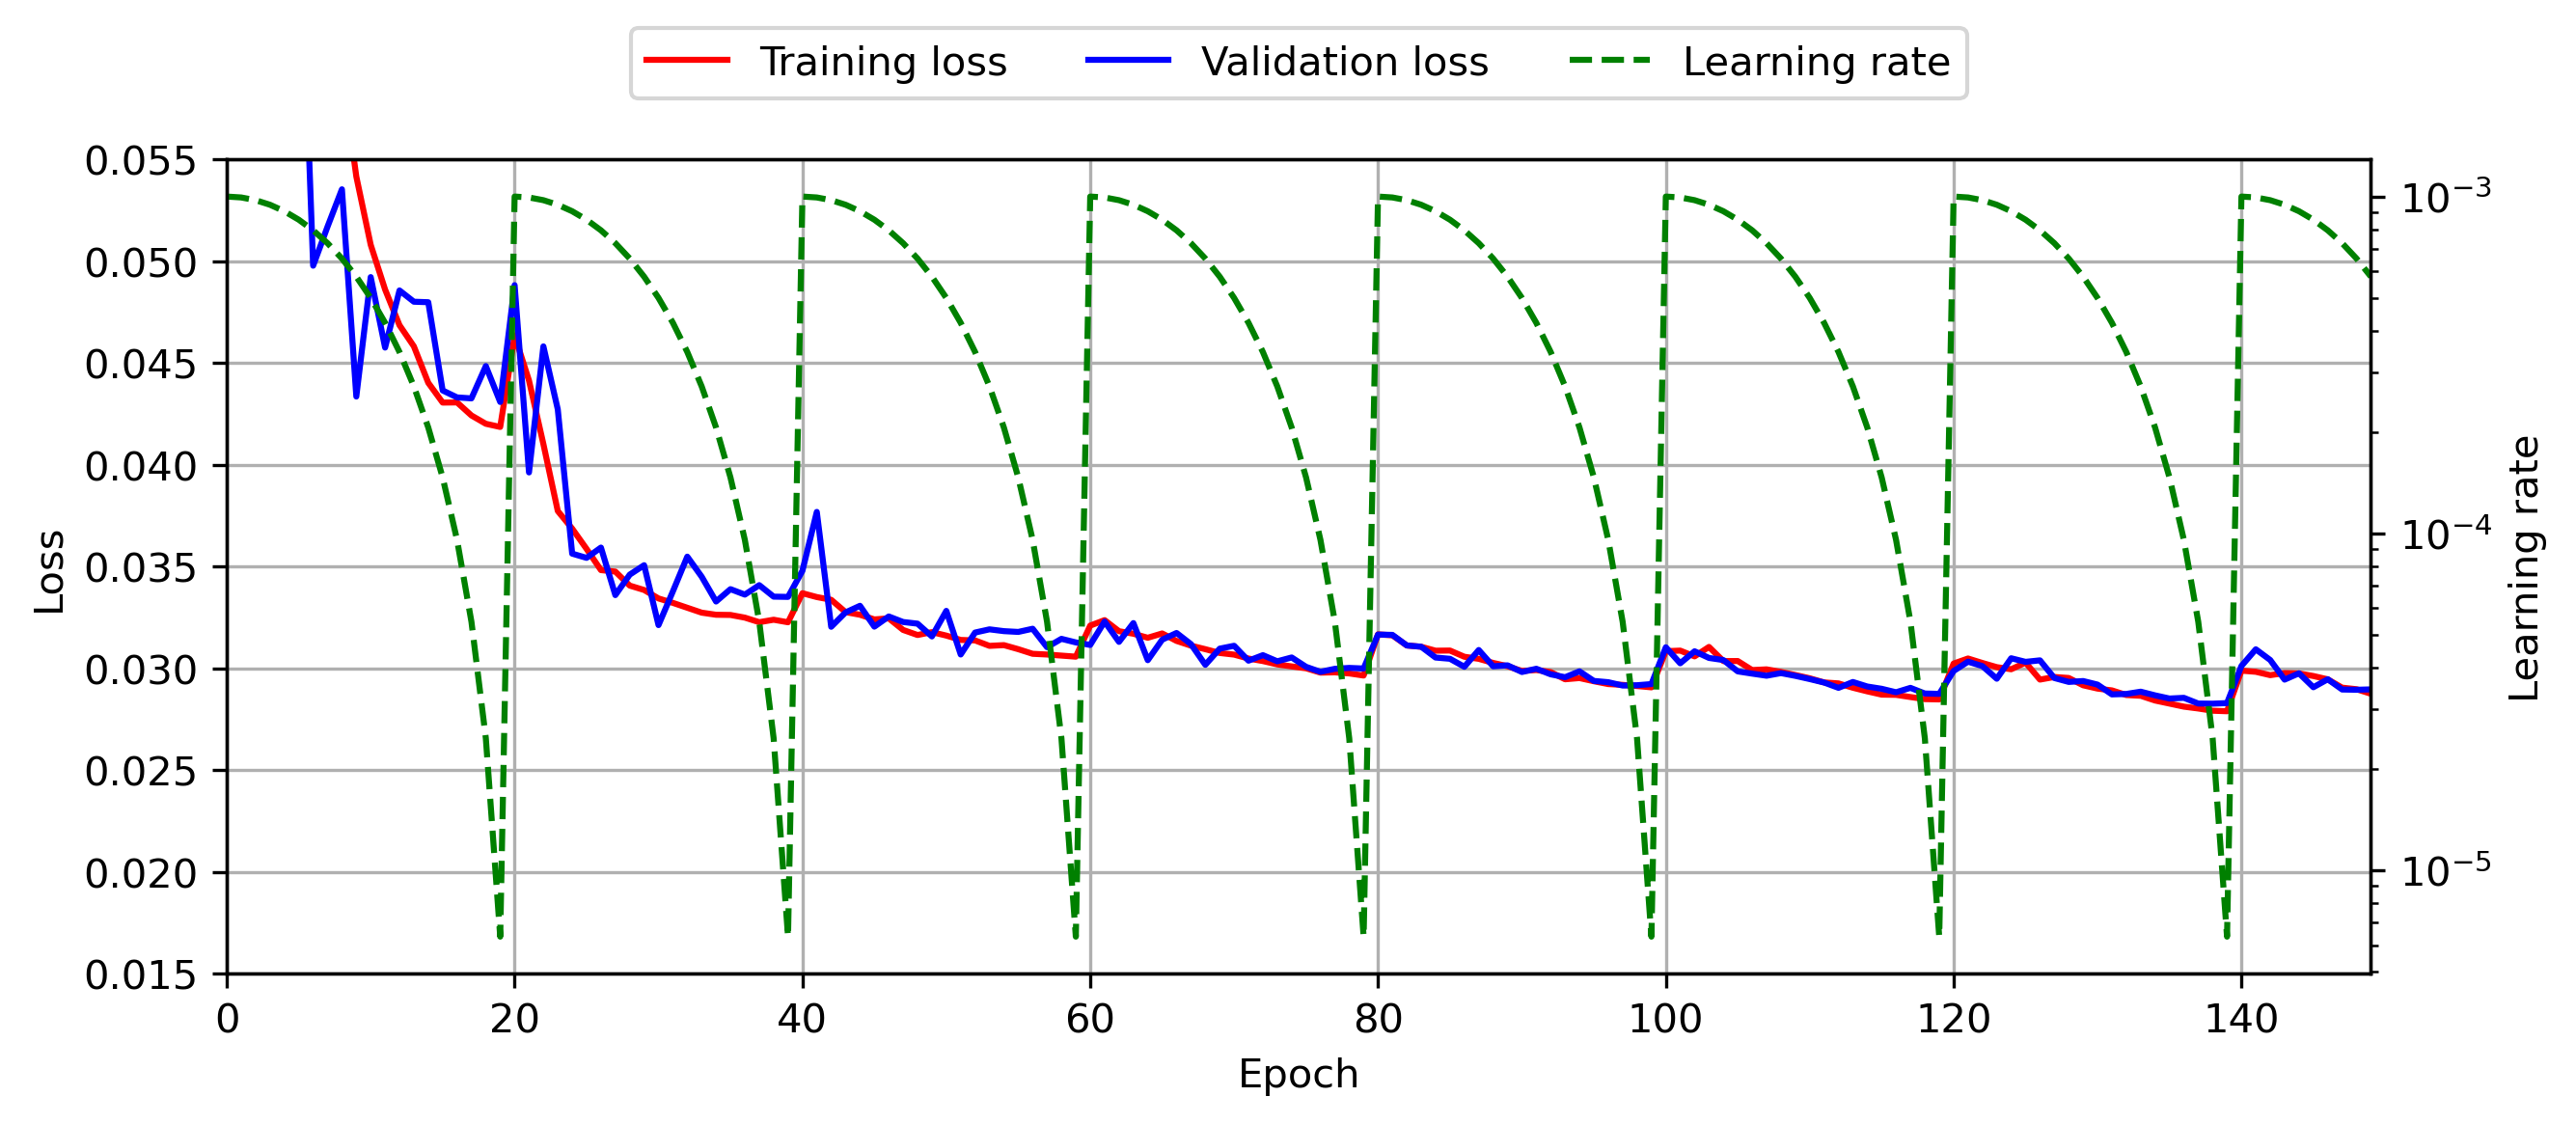

In [7]:
m0 = GNNModule(**(kwargs_gnn0 | kwargs_train))

cb_a0 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b0 = EarlyStopping(
    monitor="val_loss", mode="min", patience=kwargs_train_extra["patience_es"])
cb_c0 = LearningRateMonitor(logging_interval="epoch")
logger0 = CSVLogger(
    save_dir="logs0/", name="model0", flush_logs_every_n_steps=1)

trainer0 = pl.Trainer(
    max_epochs=kwargs_train_extra["epochs"], check_val_every_n_epoch=1,
    callbacks=[cb_a0, cb_b0, cb_c0], logger=logger0, enable_progress_bar=False)
trainer0.fit(
    model=m0, train_dataloaders=loader_train0, val_dataloaders=loader_val0)

fig0 = display_training_progress(trainer0, [0.015, 0.055])

checkpoint_file = trainer0.checkpoint_callback.best_model_path
m0 = GNNModule.load_from_checkpoint(
    checkpoint_file, **(kwargs_gnn0 | kwargs_train))
    
y_test_pred0 = torch.cat(
    trainer0.predict(m0, dataloaders=loader_test0)).detach().numpy()
y_test_true0 = torch.cat([b.y for b in loader_test0]).detach().numpy()
mae0 = np.mean(np.abs(y_test_pred0 - y_test_true0))

Let's train the "GINConv" model:

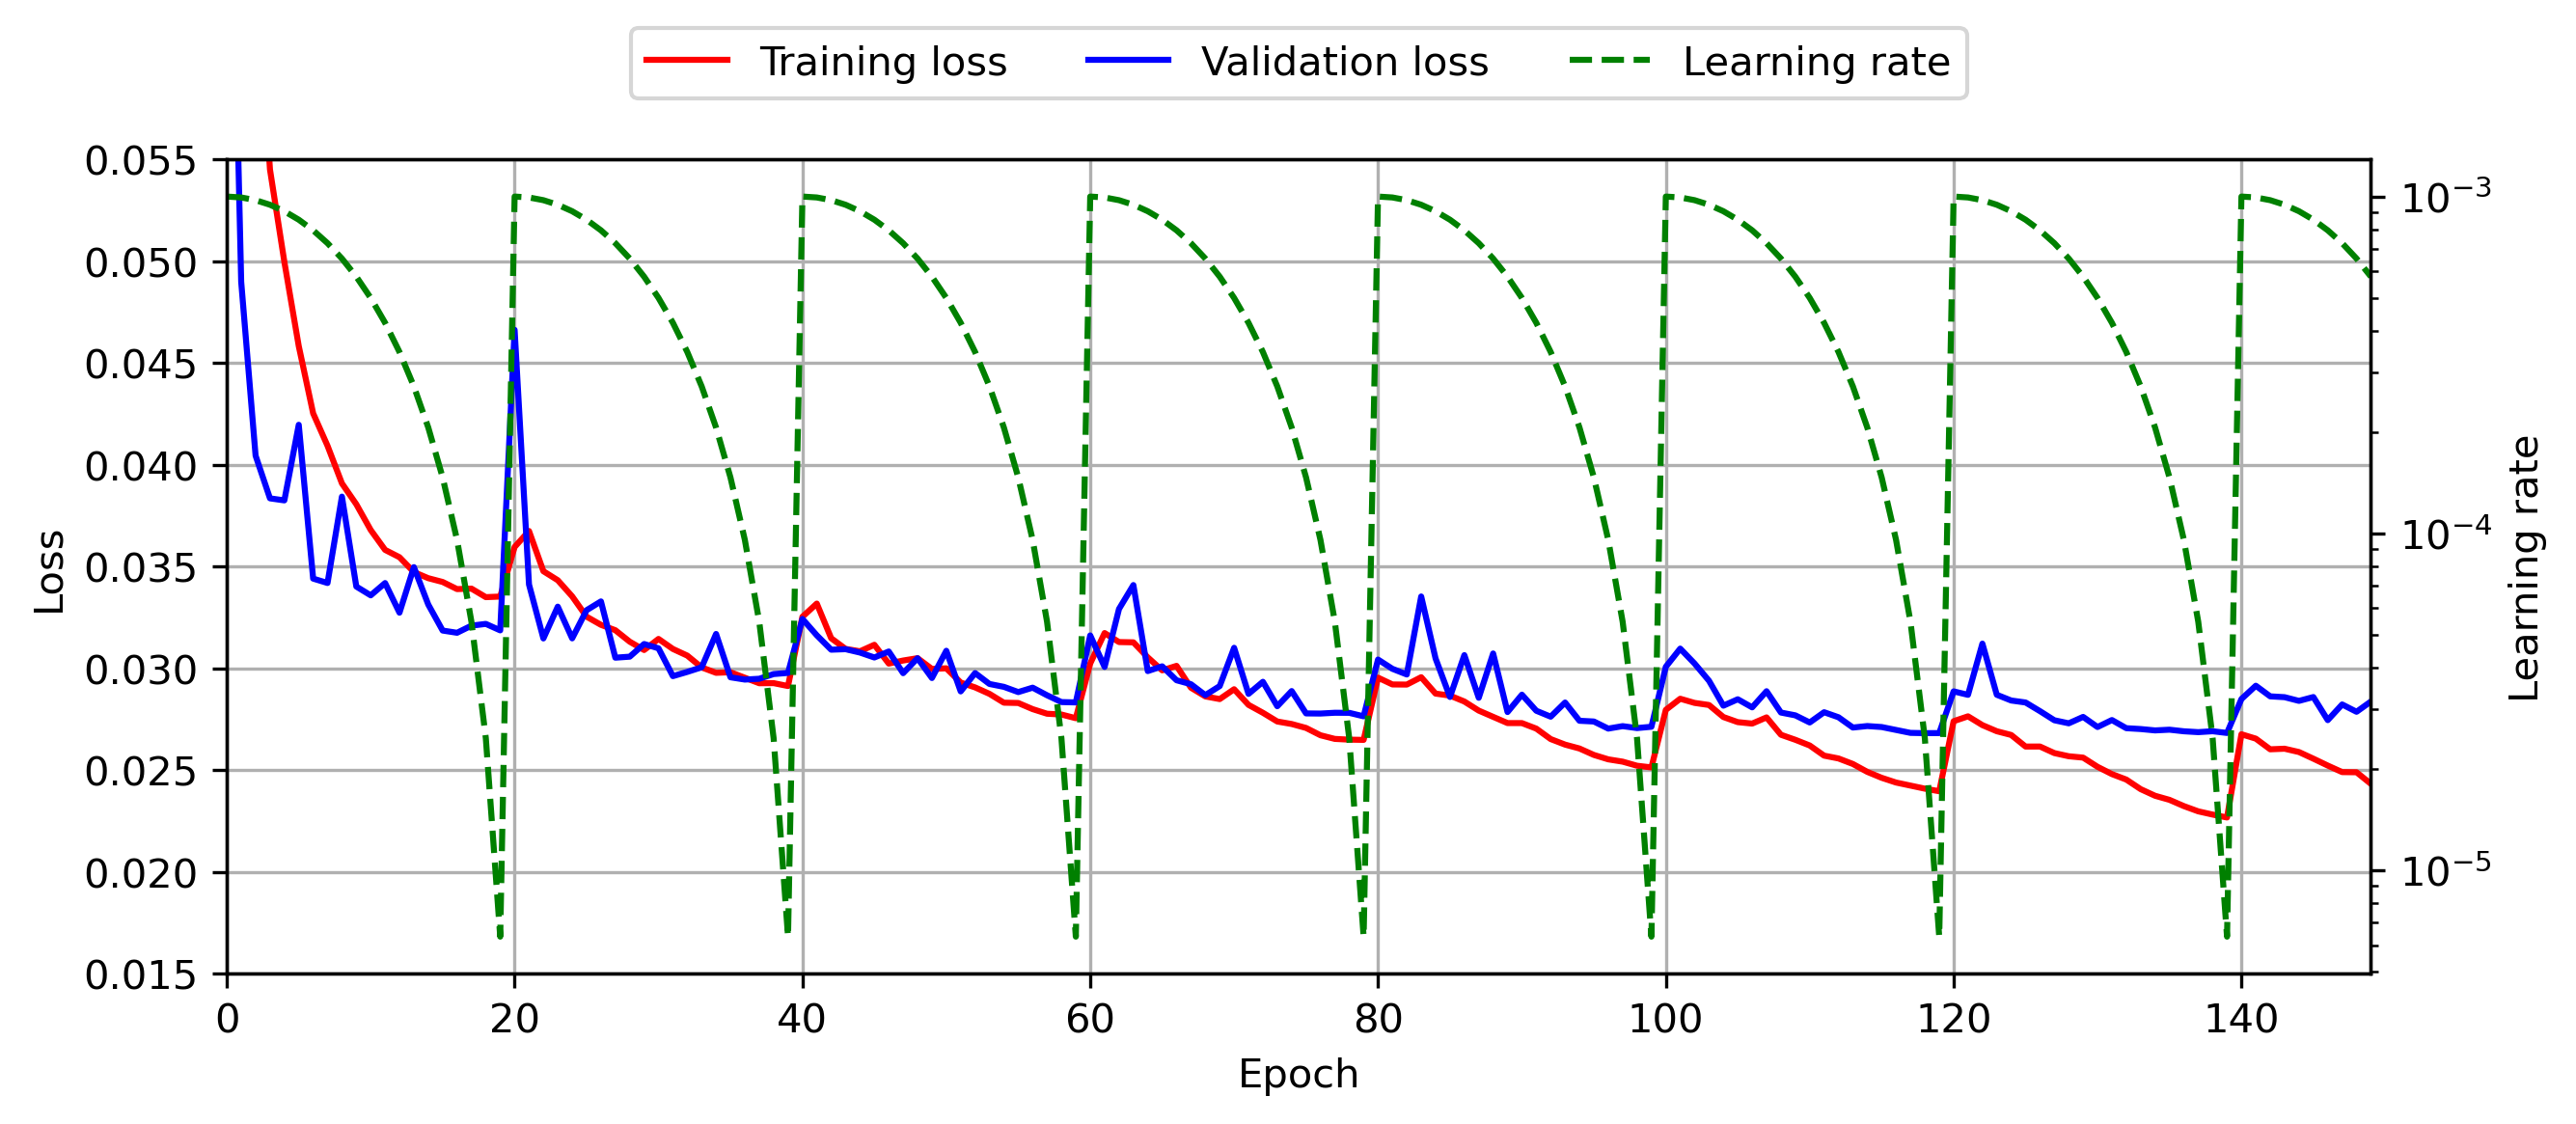

In [8]:
kwargs_gnn1 = deepcopy(kwargs_gnn0)
kwargs_gnn1["gconv_layer"] = GINConvLayer      

m1 = GNNModule(**(kwargs_gnn1 | kwargs_train))

cb_a1 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b1 = EarlyStopping(
    monitor="val_loss", mode="min", patience=kwargs_train_extra["patience_es"])
cb_c1 = LearningRateMonitor(logging_interval="epoch")
logger1 = CSVLogger(
    save_dir="logs1/", name="model1", flush_logs_every_n_steps=1)

trainer1 = pl.Trainer(
    max_epochs=kwargs_train_extra["epochs"], check_val_every_n_epoch=1,
    callbacks=[cb_a1, cb_b1, cb_c1], logger=logger1, enable_progress_bar=False)
trainer1.fit(
    model=m1, train_dataloaders=loader_train0, val_dataloaders=loader_val0)

fig1 = display_training_progress(trainer1, [0.015, 0.055])

checkpoint_file = trainer1.checkpoint_callback.best_model_path
m1 = GNNModule.load_from_checkpoint(
    checkpoint_file, **(kwargs_gnn1 | kwargs_train))
    
y_test_pred1 = torch.cat(
    trainer1.predict(m1, dataloaders=loader_test0)).detach().numpy()
y_test_true1 = torch.cat([b.y for b in loader_test0]).detach().numpy()

mae1 = np.mean(np.abs(y_test_pred1 - y_test_true1))

Let's train the "GINConv + substructure counts" model:

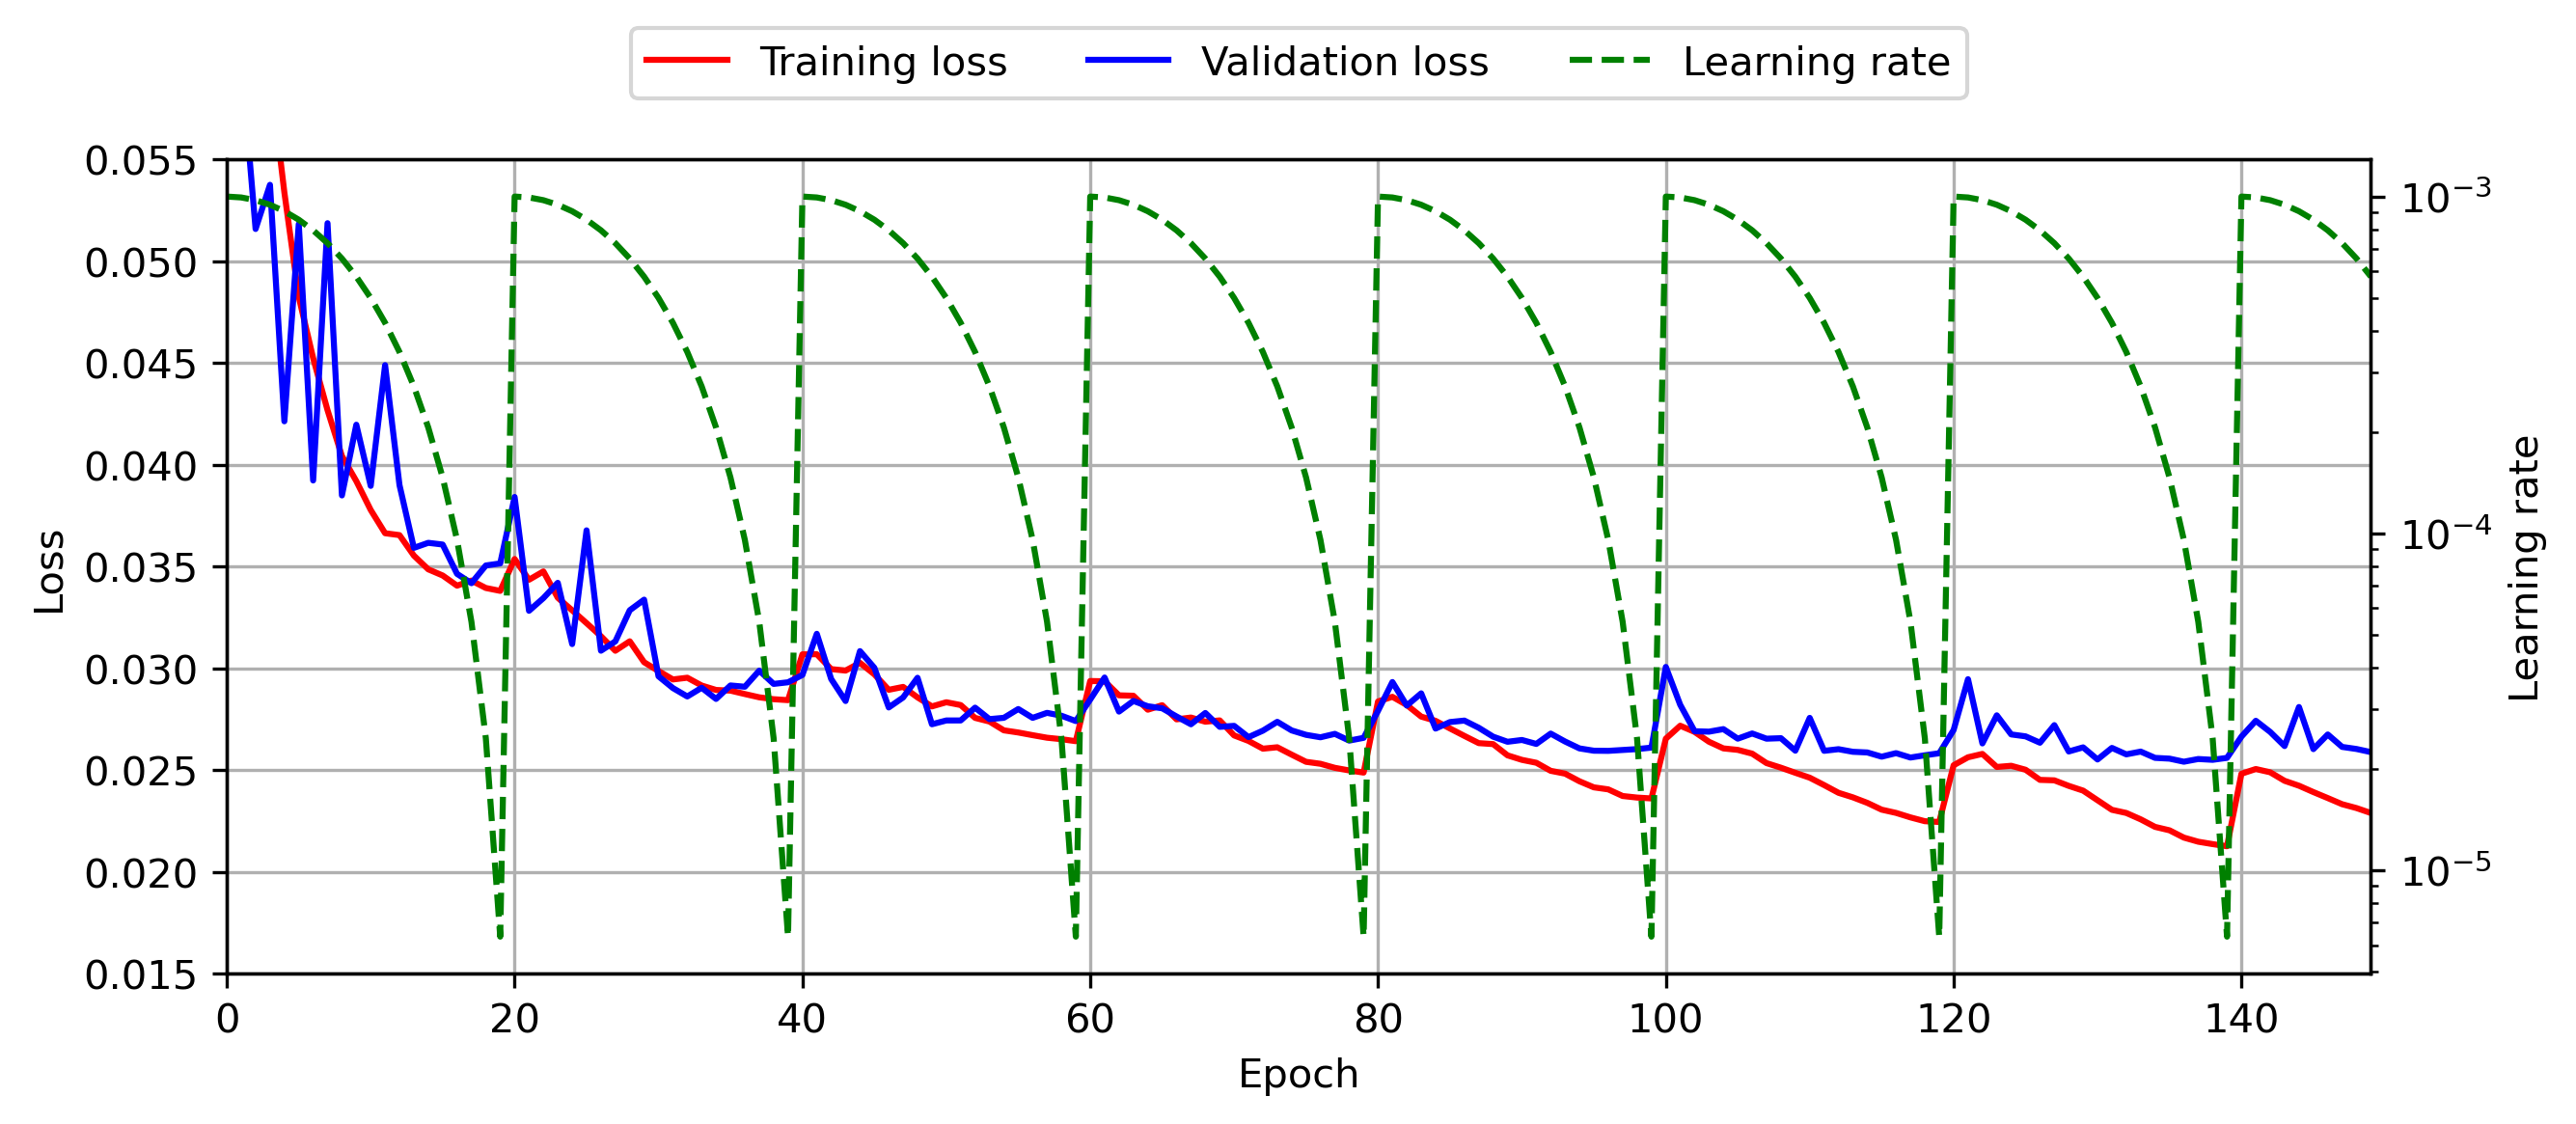

In [9]:
kwargs_gnn2 = deepcopy(kwargs_gnn1)
kwargs_gnn2["ring_sizes"] = ring_sizes      

m2 = GNNModule(**(kwargs_gnn2 | kwargs_train))

cb_a2 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b2 = EarlyStopping(
    monitor="val_loss", mode="min", patience=kwargs_train_extra["patience_es"])
cb_c2 = LearningRateMonitor(logging_interval="epoch")
logger2 = CSVLogger(
    save_dir="logs2/", name="model2", flush_logs_every_n_steps=1)

trainer2 = pl.Trainer(
    max_epochs=kwargs_train_extra["epochs"], check_val_every_n_epoch=1,
    callbacks=[cb_a2, cb_b2, cb_c2], logger=logger2, enable_progress_bar=False)
trainer2.fit(
    model=m2, train_dataloaders=loader_train2, val_dataloaders=loader_val2)

fig2 = display_training_progress(trainer2, [0.015, 0.055])

checkpoint_file = trainer2.checkpoint_callback.best_model_path
m2 = GNNModule.load_from_checkpoint(
    checkpoint_file, **(kwargs_gnn2 | kwargs_train))
    
y_test_pred2 = torch.cat(
    trainer2.predict(m2, dataloaders=loader_test2)).detach().numpy()
y_test_true2 = torch.cat([b.y for b in loader_test2]).detach().numpy()

mae2 = np.mean(np.abs(y_test_pred2 - y_test_true2))

Let's compare the results. Using the GIN layer slightly improves the performance compared to the GCN layer. Additionally incorporating substructure counts (here rings of size (3-8) further increases performance slightly: 

In [10]:
print(f"MAE of GCNConv model without ring features: {mae0:.4f}")
print(f"MAE of GINConv model without ring features: {mae1:.4f}")
print(f"MAE of GINConv model with ring features: {mae2:.4f}")

MAE of GCNConv model without ring features: 0.0281
MAE of GINConv model without ring features: 0.0268
MAE of GINConv model with ring features: 0.0254
